# Jitter issues
After closely inspecting panchromatic (as well as filtered) pixels along consequent frames, there seems to be some weired inconsistent trend (jitter) in the obtained grey levels (with a dynamic range of ~100 grey-levels).

The jitter issue is problematic since it affects the quality of the camera's modeling and calibration, and since an acquisition of a static scene can result in significant unpredictable bias differences of upto ~100 grey levels.

below is an example of the jitter in grey levels across 100K consecutively acquired frame (equivalent to ~30 minutes), at different random pixel locations:

In [1]:
from tools import plotGlAcrossFrames
from pathlib import Path
import numpy as np
path_to_files = Path("rawDajitter_21")
meas_long = np.l
    Path(path_to_ummons Carol Dfiles, "blackbody_temperature_35_wavelength_0.npy"))



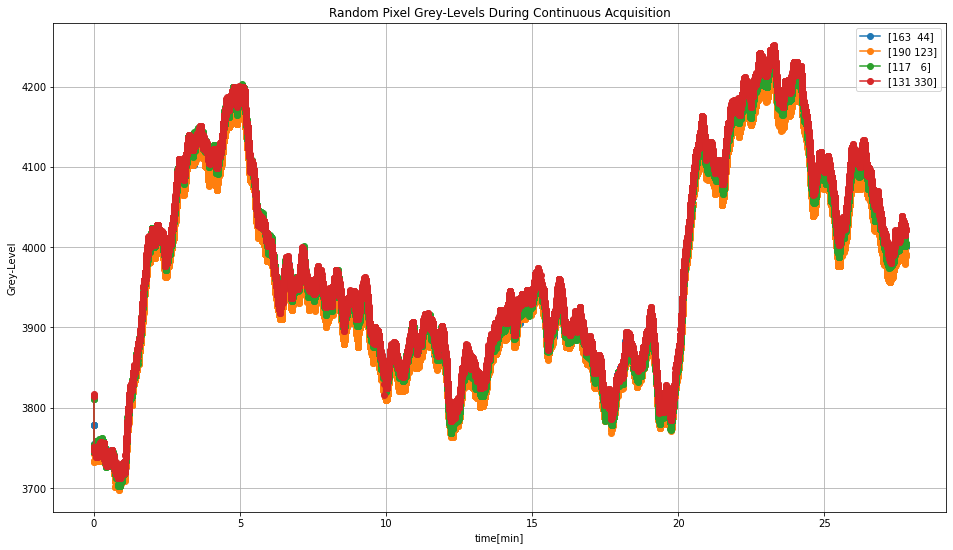

In [2]:
meas_pan = meas_long
grey_levels = plotGlAcrossFrames(meas_pan)


## Correlation To Housing/FPA temperature:

In [32]:
import pandas as pd 
temperatures = pd.read_csv(
    Path(path_to_files, "blackbody_temperature_35_wavelength_0.csv"))


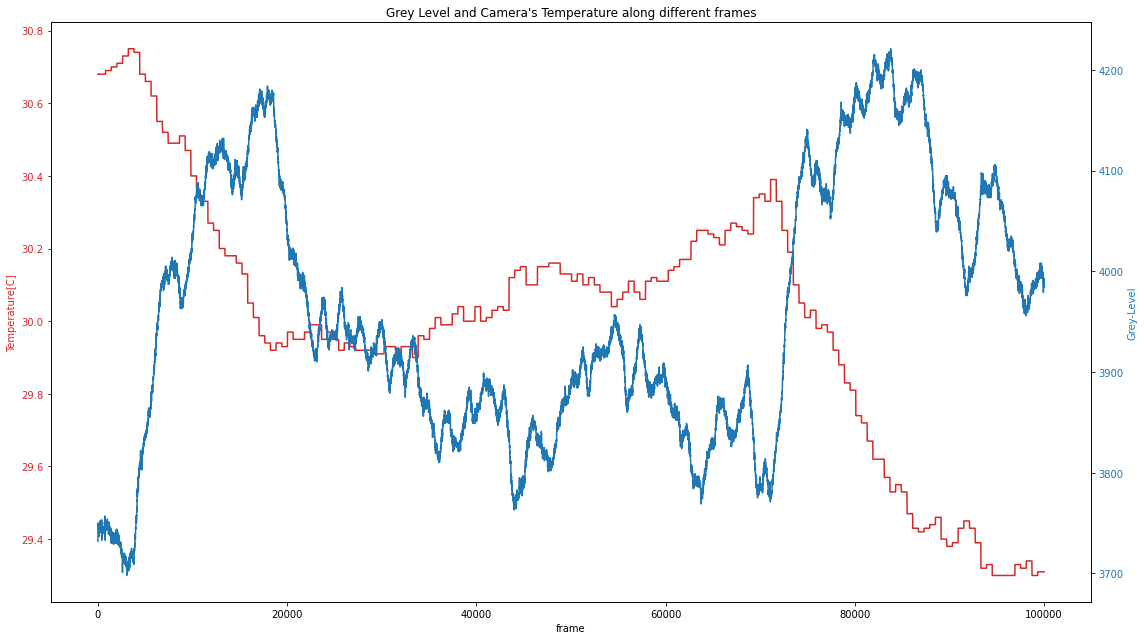

In [33]:

import matplotlib.pyplot as plt

data1 = temperatures["Housing temperature"] / 100
data2 = grey_levels[:, 1]

fig, ax1 = plt.subplots(figsize=(16, 9))

color = 'tab:red'
ax1.set_xlabel('frame')
ax1.set_ylabel('Temperature[C]', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Grey Level and Camera's Temperature along different frames")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel('Grey-Level', color=color)
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


There appears to be some negative correlation between temperature and grey-levels. 

Let's see if a linear regression can be used to de-trend the flactuations in grey-levels to some extent:

C:\Users\omriber\AppData\Local\Temp/ipykernel_12588/3512435251.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x, y = data1[:, None], data2[:, None]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Correlation Coefficients:


array([[ 1.        , -0.57942098],
       [-0.57942098,  1.        ]])

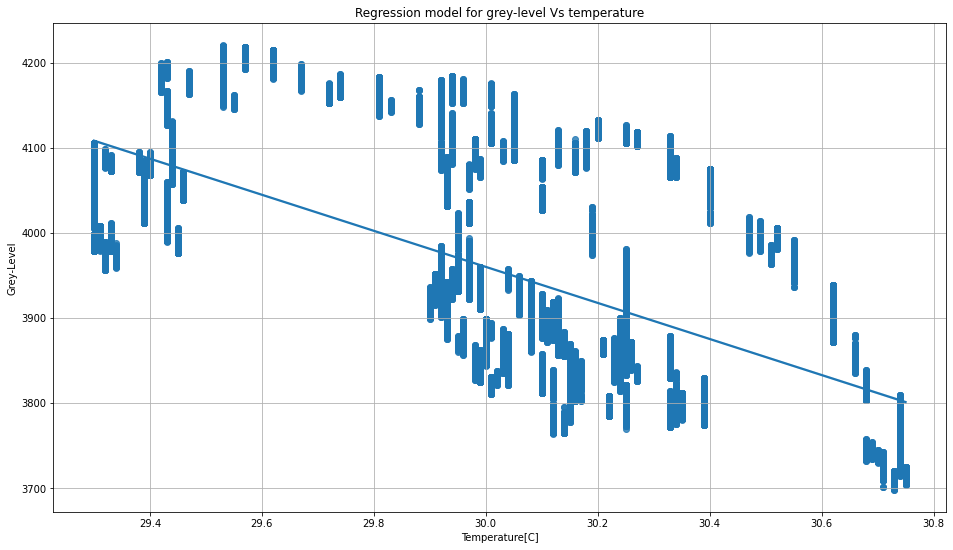

In [46]:
# first, let's display a regression model for an arbitrary pixel:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex
import seaborn as sns

x, y = data1[:, None], data2[:, None]
lr = LinearRegression().fit(x, y)
plt.figure(figsize=(16, 9))
res = sns.regplot(x=x, y=y, fit_reg=True)
plt.title(f"Regression model for grey-level Vs temperature")
plt.xlabel("Temperature[C]")
plt.ylabel("Grey-Level")
plt.grid()

display(Latex(
    fr"Regression result: $GL = {lr.coef_.squeeze():.3f} \times T +{lr.intercept_.squeeze():.3f}$"))
display(Latex(fr"$R^2 = {lr.score(x, y):.3f}$"))
print("Correlation Coefficients:")
np.corrcoef(data1, data2)


Now, let's try to correct for deviations from a fixed temperature (say - 30C) using the linear model:

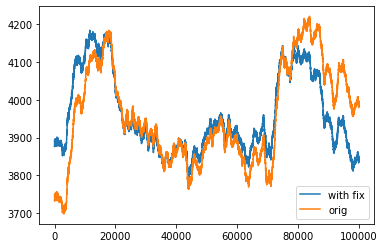

In [43]:
gl_fix = lambda T: (T-30) * lr.coef_.squeeze()
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(data2, label="orig")
ax.plot(data2 - gl_fix(data1), label="with fix")
ax.legend()
ax.set_title("FPA temperature-based Correction")
ax.set_xlabel("Frames")
ax.set_ylabel("Gray-Levels")

Correcting based on the regression seems to reduce the nuisance dynamic range from 500 to 300 grey-levels. 

To get a better regression model/corrections - we probably need to collect data over a larger span of FPA temperatures.